# Business Problem





In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [2]:
shots_df = pd.read_csv('shots_2022.csv')
buffalo_df = pd.read_csv('BUF.csv')
buffalo_player_stats = pd.read_csv('buf_player_stats.csv')
boston_player_stats = pd.read_csv('BOS.csv')
boston_df = pd.read_csv('BOS_team_stats.csv')

# Business Understanding


The Buffalo Sabres want to know how they can improve.  First we will look into what areas they need to improve on, and then dive deeper into what suggestions we can make.

The Sabres allow just as many goals as they score so focus should be minimizing the number of goals scored against them.

# Data Clean Up

I only want to focus on the most current season, the 2022 season.  Usually the more data the better, however we do not want to include players that are not on either team anymore. 

In [3]:
buffalo_2022 = buffalo_df[buffalo_df['season'] == 2022]

In [4]:
boston_df['gameId'] = boston_df['gameId'].astype(str)
boston_2022 = boston_df[boston_df['gameId'].str[:4] == '2022']

Both boston and buffalo have their own dfs that focus on the current (2022) season

In [5]:
combined_2022_df = pd.concat([boston_2022, buffalo_2022])

In [6]:
combined_2022_df.isna().sum().sum()

340

After removing the season column (we know its all 2022) there is no more missing values

In [7]:
combined_2022_df.isna().sum().sum()

340

In [8]:
combined_2022_df.drop("season", axis=1, inplace=True)

In [9]:
combined_2022_df.isna().sum().sum()

0

Now that the seasons column has been removed (we know its all the 2022 season now) there are no missing values.

# EDA

I want to compare Buffalo's total "goalsFor" and the total  "goalsAgainst" to that of Bostons.

In [10]:
situation_all_df = combined_2022_df[combined_2022_df['situation'] == 'all']
team_goals = situation_all_df.groupby('team').sum()[['goalsFor', 'goalsAgainst']]
print(team_goals)

      goalsFor  goalsAgainst
team                        
BOS      254.0         147.0
BUF      247.0         247.0


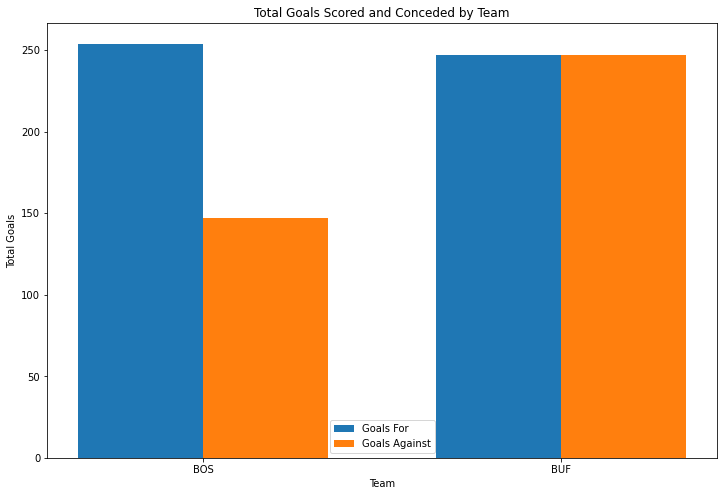

In [11]:
# Group the resulting DataFrame by the 'team' column, and sum the 'goalsFor' and 'goalsAgainst' columns within each group
team_goals = situation_all_df.groupby('team').sum()[['goalsFor', 'goalsAgainst']]

# Get the list of team names and the number of teams
team_names = list(team_goals.index)
num_teams = len(team_names)

# Create a numpy array for the goalsFor and goalsAgainst data
goals_for_data = np.array(team_goals['goalsFor'])
goals_against_data = np.array(team_goals['goalsAgainst'])

# Define the width of the bars
bar_width = 0.35

# Create a numpy array for the x-axis positions of the bars
x_positions = np.arange(num_teams)

# Set the figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Create the bars for goalsFor and goalsAgainst for each team
ax.bar(x_positions - bar_width/2, goals_for_data, bar_width, label='Goals For')
ax.bar(x_positions + bar_width/2, goals_against_data, bar_width, label='Goals Against')

# Set the title and axis labels for the chart
plt.title('Total Goals Scored and Conceded by Team')
plt.xlabel('Team')
plt.ylabel('Total Goals')

# Set the tick labels for the x-axis
ax.set_xticks(x_positions)
ax.set_xticklabels(team_names)

# Add a legend for the bars
ax.legend()

# Show the chart
plt.show()

Looking at this, we can see that Boston (a serious Stanley Cup contender) scores about 100 more goals than they let in.  Buffalo on the other hand is dead even, 247 "goalsFor", and 247 "goalsAgainst". Also, Buffalo has a total "goalsFor" that is very similar to Boston's. This tells me that Buffalo has an offense that is on par with one of the best teams in the league, but their defense is far behind.

Now we will try to explain why Boston's defense is letting in so few goals compared to Buffalo.

# Defense Analysis

I want to compare the defense for different situations for both teams to focus in on why why Boston allows so many fewer goals

Situation percentages for each team:
situation  4on5  5on4  5on5    all  other
team                                     
BOS        21.1   3.4  64.6  100.0   10.9
BUF        19.0   2.0  66.8  100.0   12.1


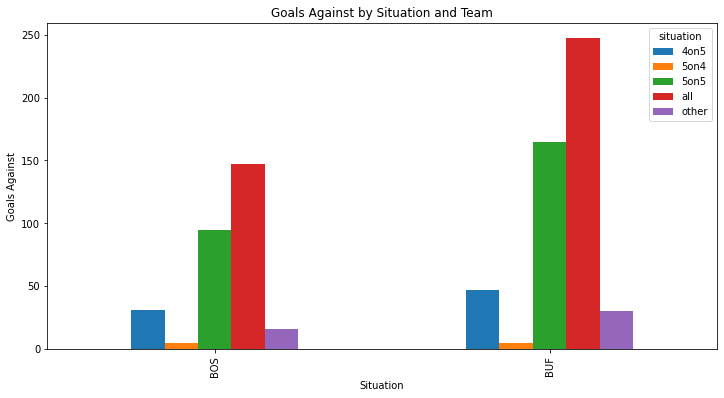

In [12]:
# Group the data by team and situation and get the sum of goalsAgainst
team_situation_goals = combined_2022_df.groupby(['team', 'situation']).sum()['goalsAgainst']

# Reshape the data to a wide format
team_situation_goals = team_situation_goals.unstack()

# Calculate the total goalsAgainst for each team
total_goals = team_situation_goals.sum(axis=1)

# Calculate the percentage of each situation's goalsAgainst out of the team's total goalsAgainst
situation_percentages = (team_situation_goals.div(total_goals, axis=0) * 100 * 2).round(1)

# Print the list of percentages for each situation
print("Situation percentages for each team:")
print(situation_percentages)

# Plot the data
team_situation_goals.plot(kind='bar', figsize=(12, 6))

# Set the plot title and labels
plt.title('Goals Against by Situation and Team')
plt.xlabel('Situation')
plt.ylabel('Goals Against')

# Show the plot
plt.show()

Percentages for both teams are close to each other for percentages of goals against in each situation. This indicates that buffalo allows too many goals all together, rather than just being particularly bad in one situation.  Next we can look into what features correlate to allowing a goal for buffalo's complete goalsAgainst total.

# Buffalo's goalsAgainst most relevant features

In [13]:
# Drop columns that contain 'flurry' or 'Flurry' in their names
buffalo_2022_filtered = buffalo_2022.drop(columns=[col for col in buffalo_2022.columns if 'flurry' in col.lower()])

# Filter the dataframe to only include rows where situation is "all"
buffalo_2022_filtered = buffalo_2022_filtered[buffalo_2022_filtered['situation'] == 'all']

# Calculate the correlation between each column and goalsAgainst
correlations = buffalo_2022_filtered.corr()['goalsAgainst']

# Get the top 12 correlations (excluding the correlation with goalsAgainst itself)
top_correlations = correlations.nlargest(13)[1:]

# Print the top 12 correlations
print(top_correlations)

highDangerGoalsAgainst                 0.672946
mediumDangerGoalsAgainst               0.595512
scoreAdjustedTotalShotCreditAgainst    0.466992
scoreVenueAdjustedxGoalsAgainst        0.393520
totalShotCreditAgainst                 0.384837
highDangerxGoalsAgainst                0.354096
lowDangerGoalsAgainst                  0.345214
reboundGoalsAgainst                    0.320879
xGoalsAgainst                          0.315013
highDangerShotsAgainst                 0.258818
playStoppedAgainst                     0.187315
gameId                                 0.168217
Name: goalsAgainst, dtype: float64


We can see that highDangerGoalsAgainst and mediumDangerGoalsAgainst are the top two correlated features to goalsAgainst.  This indicates that Buffalo is allowing teams to get to these areas to easily.  Next let's compare this list of features to the features that are relevant to Boston (cup contender) being scored on.

# Boston's goalsAgainst most relevant features

In [14]:
# Drop columns that contain 'flurry' or 'Flurry' in their names
boston_2022_filtered = boston_2022.drop(columns=[col for col in buffalo_2022.columns if 'flurry' in col.lower()])

# Filter the dataframe to only include rows where situation is "all"
boston_2022_filtered = boston_2022_filtered[boston_2022_filtered['situation'] == 'all']

# Calculate the correlation between each column and goalsAgainst
correlations = boston_2022_filtered.corr()['goalsAgainst']

# Get the top 12 correlations (excluding the correlation with goalsAgainst itself)
top_correlations = correlations.nlargest(13)[1:]

# Print the top 12 correlations
print(top_correlations)

mediumDangerGoalsAgainst               0.623421
highDangerGoalsAgainst                 0.572474
scoreAdjustedTotalShotCreditAgainst    0.520825
totalShotCreditAgainst                 0.500354
scoreVenueAdjustedxGoalsAgainst        0.474769
xGoalsAgainst                          0.458834
mediumDangerShotsAgainst               0.452626
lowDangerGoalsAgainst                  0.436365
mediumDangerxGoalsAgainst              0.436138
reboundGoalsAgainst                    0.393949
highDangerShotsAgainst                 0.359798
playContinuedInZoneFor                 0.341447
Name: goalsAgainst, dtype: float64


We see a few similar features here.  However one thing we should note here is that highDangerGoalsAgainst for Boston is lower than for Buffalo.  To me this means that Boston is doing a better job of keeping shooters out of the high danger areas.  Boston's high danger goalsAgainst are .10 lower than Buffalo.

In [15]:
situation_all_df

,team,name,gameId,playerTeam,opposingTeam,home_or_away,gameDate,position,situation,xGoalsPercentage,...,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst
1,BOS,BOS,2022020005,BOS,WSH,AWAY,20221012,Team Level,all,0.5323,...,62.005,46.0,43.172,7.0,0.538,0.212,0.212,3.082,2.937,2.801
6,BOS,BOS,2022020027,BOS,ARI,HOME,20221015,Team Level,all,0.6985,...,44.967,33.0,32.216,3.0,0.381,0.225,0.225,2.545,2.545,2.530
11,BOS,BOS,2022020041,BOS,FLA,HOME,20221017,Team Level,all,0.5490,...,77.245,56.0,55.373,0.0,0.867,1.571,1.571,3.100,3.119,3.022
16,BOS,BOS,2022020049,BOS,OTT,AWAY,20221018,Team Level,all,0.4741,...,62.238,47.0,48.161,6.0,0.557,0.509,0.509,3.989,4.007,3.965
21,BOS,BOS,2022020059,BOS,ANA,HOME,20221020,Team Level,all,0.6459,...,49.917,39.0,39.564,3.0,0.377,0.010,0.010,1.910,1.962,1.925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5691,BUF,BUF,2022021025,BUF,DAL,HOME,20230309,Team Level,all,0.2916,...,75.615,58.0,65.151,1.0,0.710,0.036,0.036,4.969,5.506,5.404
5696,BUF,BUF,2022021040,BUF,NYR,HOME,20230311,Team Level,all,0.5431,...,53.127,38.0,38.666,3.0,0.513,0.201,0.201,2.519,2.580,2.378
5701,BUF,BUF,2022021061,BUF,TOR,AWAY,20230313,Team Level,all,0.6560,...,47.833,39.0,38.148,11.0,0.385,0.266,0.266,1.970,1.911,1.869
5706,BUF,BUF,2022021076,BUF,WSH,AWAY,20230315,Team Level,all,0.4239,...,64.443,50.0,46.268,11.0,0.619,0.968,0.968,3.194,2.987,2.931


We are now looking into what the difference in goals is for Boston and Buffalo when being scored on from a high danger areas.

In [16]:
# Filter the dataframe to only include high danger goals against
high_danger_df = situation_all_df[situation_all_df['situation'] == 'all'][['team', 'goalsAgainst', 'highDangerGoalsAgainst']]

# Group the dataframe by team and sum the high danger goals against
team_high_danger_df = high_danger_df.groupby('team').sum()

# Print the resulting dataframe
print(team_high_danger_df)

      goalsAgainst  highDangerGoalsAgainst
team                                      
BOS          147.0                    51.0
BUF          247.0                    81.0


Buffalo allows 30 more goals from high danger areas.  When games can be won by one or two goals this can be a serious problem.  Buffalo is one of the top scoring teams in the league but allows so many goals.

In [17]:
shots_df

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,...,xCordAdjusted,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord,yCordAdjusted
0,0,43.0,47.0,47.0,8.0,8.0,0.000000,0,0,0,...,44,0.214393,0.026009,0.398742,0.300830,0.022987,0.037040,0.710473,8,8
1,1,51.0,45.0,45.0,26.0,26.0,0.000000,0,0,0,...,44,0.186673,0.007774,0.455486,0.294453,0.020666,0.034948,0.667152,27,27
2,2,59.0,-31.0,31.0,8.0,8.0,0.000000,0,0,0,...,33,0.256798,0.046070,0.358080,0.259696,0.027936,0.051420,0.644651,8,-8
3,3,14.0,-76.0,76.0,-4.0,4.0,0.000000,0,0,0,...,74,0.172590,0.296800,0.230564,0.183049,0.024885,0.092112,0.898032,-5,5
4,4,14.0,-82.0,82.0,12.0,12.0,0.000000,0,0,0,...,81,0.128260,0.057435,0.446106,0.286419,0.019556,0.062224,0.759405,15,-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95093,352,40.0,-58.0,58.0,-26.0,26.0,5.833333,1,0,0,...,60,0.149341,0.061693,0.457400,0.265860,0.024608,0.041097,0.740899,-24,24
95094,353,46.0,55.0,55.0,31.0,31.0,0.000000,1,0,0,...,55,0.039771,0.341653,0.280115,0.295717,0.021925,0.020818,0.441629,31,31
95095,354,72.0,-20.0,20.0,-20.0,20.0,0.000000,1,0,0,...,19,0.013367,0.467303,0.192696,0.293724,0.021852,0.011058,0.472695,-20,20
95096,355,60.0,29.0,29.0,-3.0,3.0,0.833333,1,0,0,...,30,0.008746,0.847586,0.065123,0.064332,0.007230,0.006983,0.746178,-3,-3


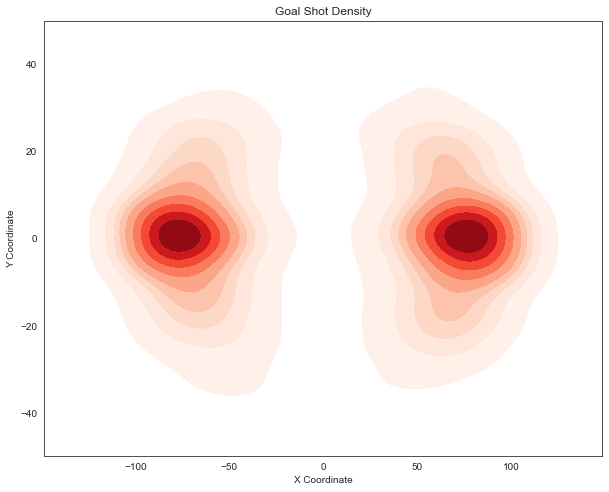

In [18]:
# Filter out the shots that didn't result in a goal
goal_shots = shots_df[shots_df["goal"] == 1]

# Set the style of the plot
sns.set_style("white")

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the goal shots density map
sns.kdeplot(x=goal_shots["xCord"], y=goal_shots["yCord"], shade=True, cmap="Reds", ax=ax)
ax.set_title("Goal Shot Density")

# Set the plot title and axis labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

# Show the plot
plt.show()

This code filters out the shots that resulted in a goal from a dataframe shots_df and stores the result in a new dataframe goal_shots. Then, it sets the style of the plot using Seaborn's set_style() function. A figure with one subplot is created, and a KDE plot of the goal shots' x and y coordinates is plotted using Seaborn's kdeplot() function with a colormap of "Reds" and a shading effect.

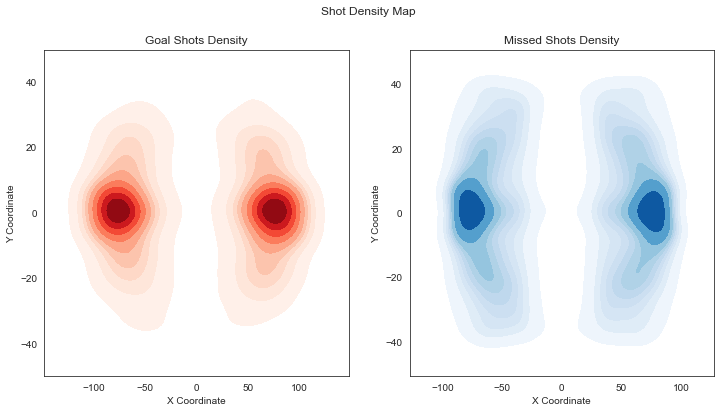

In [19]:
# Filter out the shots that didn't result in a goal
goal_shots = shots_df[shots_df["goal"] == 1]
missed_shots = shots_df[shots_df["goal"] == 0]

# Set the style of the plot
sns.set_style("white")

# Create a figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Plot the goal shots density map in the first subplot
sns.kdeplot(x=goal_shots["xCord"], y=goal_shots["yCord"], shade=True, cmap="Reds", ax=axs[0])
axs[0].set_title("Goal Shots Density")

# Plot the missed shots density map in the second subplot
sns.kdeplot(x=missed_shots["xCord"], y=missed_shots["yCord"], shade=True, cmap="Blues", ax=axs[1])
axs[1].set_title("Missed Shots Density")

# Set the plot title and axis labels
fig.suptitle("Shot Density Map")
axs[0].set_xlabel("X Coordinate")
axs[0].set_ylabel("Y Coordinate")
axs[1].set_xlabel("X Coordinate")
axs[1].set_ylabel("Y Coordinate")

# Show the plot
plt.show()

This code is similar to the above code, but also returns the shots that did not result in a goal.  We can see that the further away the shot's yCord is from the net,  the less likely a goal will be scored.

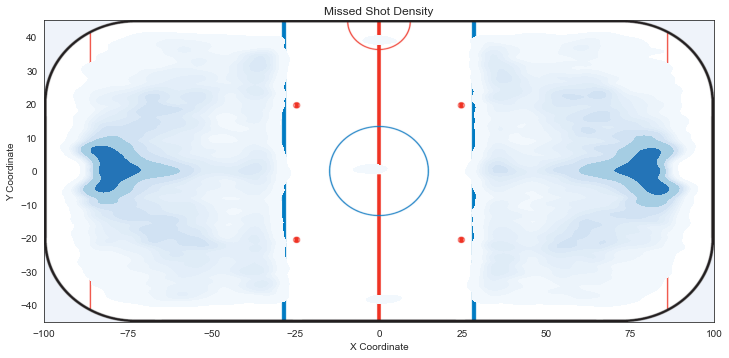

In [20]:
# Load the hockey rink image and resize it to match the plot dimensions
rink_img = mpimg.imread("hockeyRink.png")
rink_img_resized = cv2.resize(rink_img, (2000, 850))

# Filter out the shots that resulted in a goal
missed_shots = shots_df[shots_df["goal"] == 0]

# Set the style of the plot
sns.set_style("white")

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(12, 9))

# Set the x and y ranges of the plot
x_range = [-100, 100]
y_range = [-45, 45]

# Plot the hockey rink image in the background
ax.imshow(rink_img_resized, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])

sns.kdeplot(x=missed_shots["xCord"], y=missed_shots["yCord"], shade=True, cmap="Blues", ax=ax, bw_adjust=.28)

# Set the plot title and axis labels
ax.set_title("Missed Shot Density")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

# Set the x and y limits of the plot
ax.set_xlim(x_range)
ax.set_ylim(y_range)

# Show the plot
plt.show()

The above density map shows is showing us where shots are not resulting in goals.  The dark blue area has the msot frequent amount of shots that are missed,  but only because this is where the most shots come from.  The big information we can take from this density map and the opposite (showing shots that were goals) is that shots that were closer to the boards are more likely to miss.

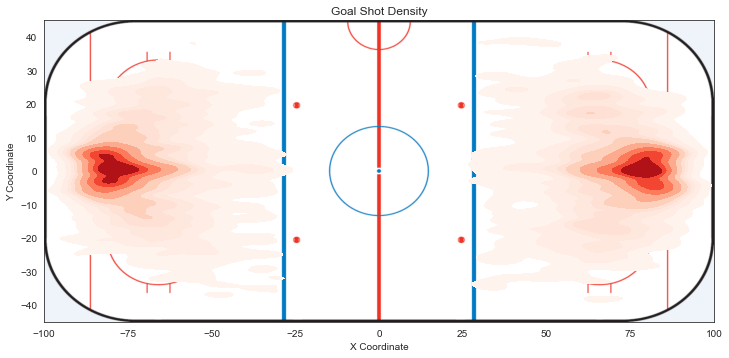

In [21]:
# Load the hockey rink image and resize it to match the plot dimensions
rink_img = mpimg.imread("hockeyRink.png")
rink_img_resized = cv2.resize(rink_img, (2000, 850))

# Filter out the shots that didn't result in a goal
goal_shots = shots_df[shots_df["goal"] == 1]

# Set the style of the plot
sns.set_style("white")

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(12, 9))

# Set the x and y ranges of the plot
x_range = [-100, 100]
y_range = [-45, 45]

# Plot the hockey rink image in the background
ax.imshow(rink_img_resized, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])

sns.kdeplot(x=goal_shots["xCord"], y=goal_shots["yCord"], shade=True, cmap="Reds", ax=ax, bw_adjust=.28)

# Set the plot title and axis labels
ax.set_title("Goal Shot Density")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

# Set the x and y limits of the plot
ax.set_xlim(x_range)
ax.set_ylim(y_range)

# Show the plot
plt.show()

This code loads an image of a hockey rink, resizes it to match the plot dimensions, and filters out the shots that did not result in a goal. Then, it creates a plot with the hockey rink image in the background and a kernel density estimate (KDE) plot of the goal shots' x and y coordinates in the foreground. The goal of the code is to visualize the density of shots that resulted in goals on a hockey rink.



From this density map we can see that as a shooter is pushed out towards the boards (towards -45 or 45) that shooters chance of scoring goes down.  This makes me curious to see what would happen if a random 25% of shots were moved out towards the boards by a few feet.

# Model predicting new shots that are moved 5 feet out towards the boards

First, we will isolate the shots that are in between -10 and 10 "yCord".  My plan is to show the effects of pushing a shooter out more towards the boards.

In [22]:
# Filter shots_df to only include shots with yCord between -10 and 10
yCord_shots = shots_df[(shots_df['yCord'] >= -10) & (shots_df['yCord'] <= 10)]

In [23]:
# Filter the columns that don't have "adjusted" or "Adjusted" in their column names
yCord_shots = yCord_shots.filter(regex='^(?!.*[aA]djusted).*$')

In [24]:
yCord_shots

,shotID,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,awaySkatersOnIce,awayTeamCode,awayTeamGoals,defendingTeamAverageTimeOnIce,defendingTeamAverageTimeOnIceOfDefencemen,...,timeUntilNextEvent,xCord,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord
0,0,0.000000,0,0,0,5,SJS,0,23.000000,23.0,...,1,44,0.214393,0.026009,0.398742,0.300830,0.022987,0.037040,0.710473,8
2,2,0.000000,0,0,0,5,SJS,0,35.000000,35.0,...,2,-33,0.256798,0.046070,0.358080,0.259696,0.027936,0.051420,0.644651,8
3,3,0.000000,0,0,0,5,SJS,0,37.000000,37.0,...,0,-74,0.172590,0.296800,0.230564,0.183049,0.024885,0.092112,0.898032,-5
5,5,0.000000,0,0,0,5,SJS,0,36.000000,36.0,...,22,-68,0.088519,0.060461,0.464366,0.316184,0.026235,0.044235,0.401010,9
6,6,-5.800000,0,0,0,5,SJS,0,42.600000,46.5,...,25,72,0.083920,0.084009,0.454167,0.309893,0.022000,0.046011,0.536515,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95083,342,0.000000,0,120,12,4,CBJ,4,1.000000,1.0,...,2,66,0.216450,0.074031,0.416961,0.181989,0.035184,0.075386,0.869841,1
95084,343,0.000000,0,120,6,4,CBJ,4,7.000000,7.0,...,9,73,0.180888,0.122011,0.323506,0.277812,0.038504,0.057279,0.523065,5
95085,344,2.000000,0,0,0,5,CBJ,4,13.400000,16.0,...,2,77,0.099365,0.092506,0.455544,0.269046,0.029801,0.053737,0.558748,0
95090,349,-8.200000,0,0,0,5,CBJ,4,25.600000,33.0,...,0,79,0.132800,0.179593,0.356378,0.245688,0.021676,0.063865,0.891525,-2


In [25]:
num_goals = len(yCord_shots[yCord_shots['goal'] == 1])
print("Number of shots that were a goal:", num_goals)

Number of shots that were a goal: 4499


There were 4,499 goals in between -10 and 10 coords.

In [26]:
# select columns with "x" or "X" in the column title, as well as the "yCord" column
x_cols = yCord_shots.filter(regex='^(yCord|[xX].*|goal)$')

# create the new dataframe with only the selected columns
x_yCord_shots = yCord_shots[x_cols.columns]

# display the new dataframe
x_yCord_shots

,goal,xCord,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord
0,0,44,0.214393,0.026009,0.398742,0.300830,0.022987,0.037040,0.710473,8
2,0,-33,0.256798,0.046070,0.358080,0.259696,0.027936,0.051420,0.644651,8
3,1,-74,0.172590,0.296800,0.230564,0.183049,0.024885,0.092112,0.898032,-5
5,0,-68,0.088519,0.060461,0.464366,0.316184,0.026235,0.044235,0.401010,9
6,0,72,0.083920,0.084009,0.454167,0.309893,0.022000,0.046011,0.536515,2
...,...,...,...,...,...,...,...,...,...,...
95083,0,66,0.216450,0.074031,0.416961,0.181989,0.035184,0.075386,0.869841,1
95084,0,73,0.180888,0.122011,0.323506,0.277812,0.038504,0.057279,0.523065,5
95085,0,77,0.099365,0.092506,0.455544,0.269046,0.029801,0.053737,0.558748,0
95090,1,79,0.132800,0.179593,0.356378,0.245688,0.021676,0.063865,0.891525,-2


We select columns from a dataframe yCord_shots based on whether their column name contains "x" or "X" or is equal to "yCord". The selected columns are stored in a new dataframe x_cols. Then, a new dataframe x_yCord_shots is created with only the selected columns from yCord_shots. Finally, the new dataframe x_yCord_shots is displayed. The goal of this code is to filter and select specific columns from a dataframe based on their column name.

# linear Regression

In [27]:
# create a new column with the modified yCord values
x_yCord_shots['yCord_modified'] = x_yCord_shots['yCord'].apply(lambda x: x+5 if x >= 0 else x-5)

# select features and target
X = x_yCord_shots.drop(['xGoal'], axis=1) # exclude the 'xGoal' column
y = x_yCord_shots['xGoal']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# make predictions on the modified yCord values
X_modified = X.copy()
X_modified['yCord'] = x_yCord_shots['yCord_modified']
y_pred = model.predict(X_modified)

# calculate the number of shots predicted to be goals
num_predicted_goals = sum(y_pred >= 0.5)
print("Number of shots predicted to be goals with modified yCord values:", num_predicted_goals)

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("RMSE:", rmse)

Number of shots predicted to be goals with modified yCord values: 760
RMSE: 0.007906560312003924


<ipython-input-27-26a25a1cf371>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_yCord_shots['yCord_modified'] = x_yCord_shots['yCord'].apply(lambda x: x+5 if x >= 0 else x-5)


Our code is using a linear regression model to predict the number of goals scored based on the position of the shot on the hockey rink. It first modifies the position of the shots, then selects the features and target, splits the data into training and testing sets, fits the linear regression model, and finally makes predictions on the modified shot positions to calculate the number of shots predicted to be goals.

In [28]:
# create OLS regression summary
X_train = sm.add_constant(X_train) # add constant term to the model
model_OLS = sm.OLS(y_train, X_train).fit()
print(model_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  xGoal   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.792e+06
Date:                Tue, 04 Apr 2023   Prob (F-statistic):               0.00
Time:                        13:58:12   Log-Likelihood:             1.2809e+05
No. Observations:               33208   AIC:                        -2.562e+05
Df Residuals:                   33197   BIC:                        -2.561e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

The R-squared value of 0.998 tells us that the other features in the dataset explain 99.8% of the variation in xGoal.

The coefficients show how much each feature affects xGoal. For example, a one-unit increase in xFroze would result in a 0.9996 decrease in xGoal.

The P-values show whether each feature is statistically significant in predicting xGoal. A p-value less than 0.05 is considered significant, and xShotWasOnGoal is highly significant with a p-value of 0.000.

The standard errors show how much the coefficients vary from sample to sample. Smaller standard errors indicate more precise coefficients.

The confidence intervals show the range within which the true coefficient value is expected to fall with 95% confidence. For example, the coefficient for xPlayStopped has a 95% confidence interval of -0.980 to -0.966, meaning that we can be 95% confident that the true effect of xPlayStopped on xGoal falls within that range.



### Residual Plot
A residual plot shows the difference between the predicted values and the actual values. It helps you to identify any patterns in the residuals, which can indicate if the model is performing well or not.

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


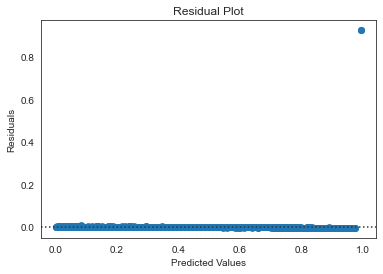

In [29]:
# create the residual plot
residuals = y_pred - y
sns.residplot(y_pred, residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

The residual plot appears as a straight line along the y-axis at zero, it indicates that the model is doing a good job of capturing the variation in the data

### Actual vs. Predicted Plot
This plot shows the actual values plotted against the predicted values. This can help you see how well the model is predicting the actual values.

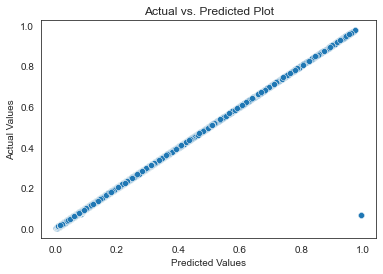

In [30]:
# create the actual vs. predicted plot
sns.scatterplot(y_pred, y)
plt.title('Actual vs. Predicted Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

The actual vs. predicted plot is a scatterplot of the predicted goal values (on the x-axis) versus the actual goal values (on the y-axis) for each shot.  Here we see almost a perfect diaganol line indicating that most of the predictions were very close to the actual values.

### Distribution Plot
This plot shows the distribution of the actual and predicted values. If the two distributions overlap, it indicates that the model is performing well.

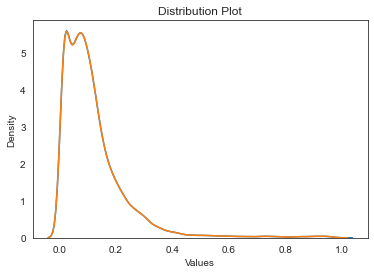

In [31]:
# create the distribution plot
sns.kdeplot(y_pred, label='Predicted Values')
sns.kdeplot(y, label='Actual Values')
plt.title('Distribution Plot')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

The line on this distribution plot looks almost like a single line, confirming that the features used to predict XGoal are highly correlated.  

# Decision Tree

In [32]:
# create a new column with the modified yCord values
x_yCord_shots['yCord_modified'] = x_yCord_shots['yCord'].apply(lambda x: x+5 if x >= 0 else x-5)

# select features and target
X = x_yCord_shots.drop(['xGoal'], axis=1) # exclude the 'goal' column
y = x_yCord_shots['xGoal']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit a decision tree regression model
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# make predictions on the modified yCord values
X_modified = X.copy()
X_modified['yCord'] = x_yCord_shots['yCord_modified']
y_pred = model.predict(X_modified)

# calculate the number of shots predicted to be goals
num_predicted_goals = sum(y_pred >= 0.5)
print("Number of shots predicted to be goals with modified yCord values:", num_predicted_goals)

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("RMSE:", rmse)

<ipython-input-32-4807d036ca38>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_yCord_shots['yCord_modified'] = x_yCord_shots['yCord'].apply(lambda x: x+5 if x >= 0 else x-5)


Number of shots predicted to be goals with modified yCord values: 747
RMSE: 0.009104864310570442


Using decision decision tree regressor we get a number of 743 shots would be goals, however it is less accurate.

In [33]:
# add the predicted goals as a new column in the original dataframe
x_yCord_shots['xGoal_predicted'] = y_pred

# fit an OLS regression model
ols_model = sm.OLS(y, X)
ols_results = ols_model.fit()

# print the regression summary
print(ols_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  xGoal   R-squared (uncentered):                   0.841
Model:                            OLS   Adj. R-squared (uncentered):              0.841
Method:                 Least Squares   F-statistic:                          2.190e+04
Date:                Tue, 04 Apr 2023   Prob (F-statistic):                        0.00
Time:                        13:58:13   Log-Likelihood:                          53111.
No. Observations:               41510   AIC:                                 -1.062e+05
Df Residuals:                   41500   BIC:                                 -1.061e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

<ipython-input-33-0bb4127ec10e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_yCord_shots['xGoal_predicted'] = y_pred


The dependent variable is xGoal, and there are 10 independent variables.

The model has an R-squared value of 0.841, which means that 84.1% of the variability in xGoal can be explained by the independent variables in the model.

The model is statistically significant with a p-value of 0.00 for the F-statistic.

The coefficients for the independent variables indicate the direction and strength of their relationship with the dependent variable. For example, a one-unit increase in the variable xShotWasOnGoal is associated with a 0.62 increase in the xGoal.

# Residual Plot

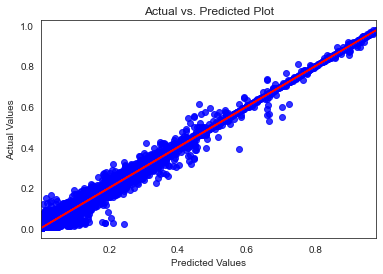

In [34]:
sns.regplot(x=y_pred, y=y, color='blue')
plt.plot(y, y, color='red')  # add a line for actual values
plt.title('Actual vs. Predicted Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

A residual plot with no clear pattern indicates that the model's predictions are not systematically biased in any particular direction, meaning that the model is not consistently over-predicting or under-predicting the target variable. This is generally a good sign and suggests that the model is a good fit for the data.

# Actual vs. Predicted

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


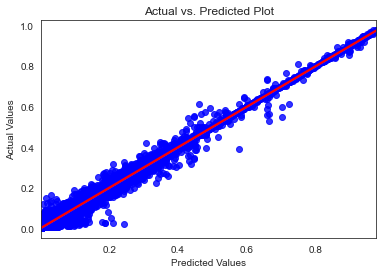

In [35]:
# create the actual vs. predicted plot
sns.regplot(y_pred, y, color='blue', line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

we can see that there are some inaccuracies in the model's predictions, as some points are further from the diagonal line.

# Distribution Plot

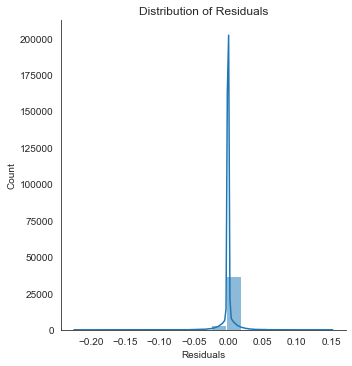

In [36]:
# create the distribution plot
sns.displot(y-y_pred, kde=True)

# add labels and title
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

A distribution plot with a spike at 0 on the x-axis indicates that the residuals are centered around 0, which is a good thing. The fact that the x-axis only goes from -0.20 to 0.15 means that the residuals are mostly concentrated in a narrow range

As of now I'd prefer to go with the linear regression because it is more accuarate than the decision tree. 

# Random Forest

In [37]:
# create a new column with the modified yCord values
x_yCord_shots['yCord_modified'] = x_yCord_shots['yCord'].apply(lambda x: x+5 if x >= 0 else x-5)

# select features and target
X = x_yCord_shots.drop(['xGoal'], axis=1) # exclude the 'goal' column
y = x_yCord_shots['xGoal']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit a random forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# make predictions on the modified yCord values
X_modified = X.copy()
X_modified['yCord'] = x_yCord_shots['yCord_modified']
y_pred = model.predict(X_modified)

# calculate the number of shots predicted to be goals
num_predicted_goals = sum(y_pred >= 0.5)
print("Number of shots predicted to be goals with modified yCord values:", num_predicted_goals)

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("RMSE:", rmse)

<ipython-input-37-50721bfd8ef5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_yCord_shots['yCord_modified'] = x_yCord_shots['yCord'].apply(lambda x: x+5 if x >= 0 else x-5)


Number of shots predicted to be goals with modified yCord values: 749
RMSE: 0.008478132345079603


According to the RMSE, this Random Forests model is so far the least accurate of the models predicting how many goals would have been scored when pushed out of the high danger zone. After running a linear regression model, and decision tree model, and a random forest model, the linear regression model had the most accurate baseline model, so we will work with that from here on out.

# Residual Plot

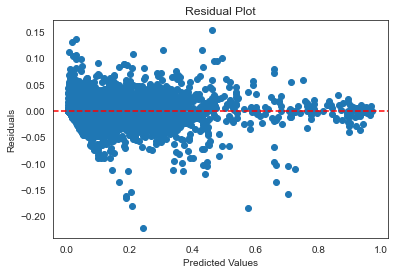

In [38]:
# make predictions on the test set
y_pred = model.predict(X_test)

# calculate the residuals
residuals = y_test - y_pred

# create a residual plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

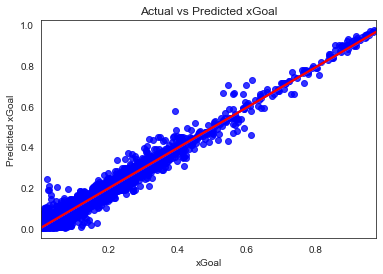

In [39]:
# create the plot
sns.regplot(x=y_test, y=y_pred, color='b')

# add labels and title
plt.xlabel('Actual xGoal')
plt.ylabel('Predicted xGoal')
plt.title('Actual vs Predicted xGoal')

# add regression line
sns.regplot(x=y_test, y=y_pred, scatter=False, color='red')

# display the plot
plt.show()

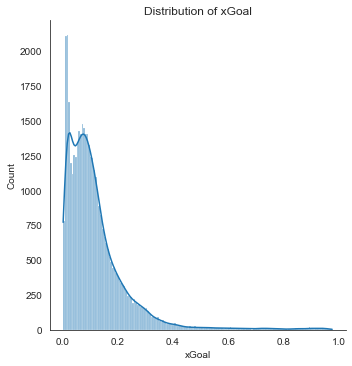

In [40]:
# create a histogram of the target variable
sns.displot(data=x_yCord_shots, x="xGoal", kde=True)

# add labels and title
plt.xlabel('xGoal')
plt.ylabel('Count')
plt.title('Distribution of xGoal')
plt.show()

# Looking into the importance of rebounds while defending

As we explore ways to improve the Sabres' defense, we have identified an additional factor that plays a crucial role in determining if a shot results in a goal. Specifically, we want to investigate the impact of rebounds on goal scoring and identify which types of shots are most likely to result in rebounds. By doing so, we hope to provide our goalie with valuable insights into which shots are most likely to pose a significant threat even after the initial save.

In [41]:
# calculate the correlation matrix for the DataFrame
corr_matrix = shots_df.corr()

# select the correlation value between "xGoal" and "xRebound"
corr_xGoal_xRebound = corr_matrix.loc["xGoal", "xRebound"]

# print the correlation value
print("Correlation between xGoal and xRebound:", corr_xGoal_xRebound)

Correlation between xGoal and xRebound: 0.29491126300257775


A coefficient of 0.295 indicates that there is a tendency for higher values of xRebound to be associated with higher values of xGoal, but the strength of this relationship is only moderate.  However when looking at the correlation between just Buffalo's goals against and rebounds, there is a stronger correlation suggesting that buffalo does worse than average at defending against rebounds.

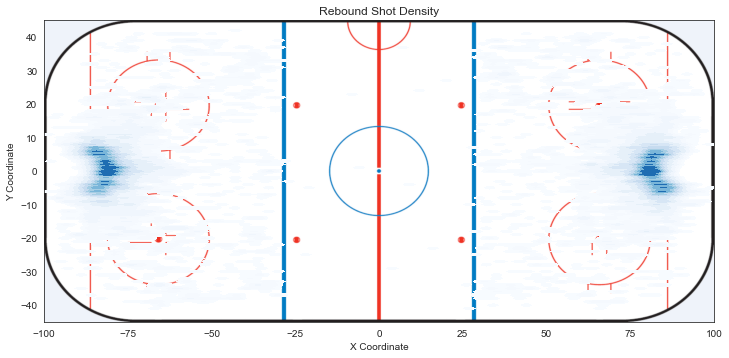

In [42]:
# Load the hockey rink image and resize it to match the plot dimensions
rink_img = plt.imread("hockeyRink.png")
rink_img_resized = cv2.resize(rink_img, (2000, 850))

# Filter the shots that resulted in a rebound
rebound_shots = shots_df[shots_df["shotRebound"] == 1]

# Set the style of the plot
sns.set_style("white")

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(12, 9))

# Set the x and y ranges of the plot
x_range = [-100, 100]
y_range = [-45, 45]

# Plot the hockey rink image in the background
ax.imshow(rink_img_resized, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])

# Create a density plot of the rebound shots
sns.kdeplot(x=rebound_shots["xCord"], y=rebound_shots["yCord"], shade=True, cmap="Blues", ax=ax, bw_adjust=.1)

# Set the plot title and axis labels
ax.set_title("Rebound Shot Density")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

# Set the x and y limits of the plot
ax.set_xlim(x_range)
ax.set_ylim(y_range)

# Show the plot
plt.show()

The density map presented above provides valuable insights for the goalies and defense of the team, highlighting the most frequent areas where rebound shots tend to occur. By sharing this information with the Sabres' goalies, they can gain a strategic advantage by knowing precisely where to anticipate the puck's location and be prepared to react quickly to freeze the puck, halting play.

In addition to the advantage gained by goalies, the density map can also be a useful tool for defensemen, providing them with insights into the areas of the ice where the opposing team is likely to generate rebound shots. Armed with this information, defensemen can anticipate the puck's trajectory and be better positioned to retrieve it. Moreover, with a clear understanding of the most common rebound areas, they can take proactive measures to prevent the opposing team from scoring altogether by disrupting the play and moving the puck out of the defensive zone. By doing so, they can contribute to the team's overall defensive strategy and help minimize the chances of a goal being scored against them.

# Summary

The Baseline Linear Regression Model seems to be the most accurate.  It predicts that out of the 4,499 goals scored in and near the high danger zone, only 760 of them would be goals if the shooter was pushed out another 5 feet.  If the sabres apply the strategy of pushing a player further away from the center of the ice, they will greatly reduce the chance that the shooter will score.

The density map can provide valuable insights for both goalies and defensemen, highlighting the most frequent areas where rebound shots tend to occur. By knowing precisely where to anticipate the puck's location, the Sabres' goalies can gain a strategic advantage and be prepared to react quickly. Similarly, defensemen can use the information to anticipate the puck's trajectory, retrieve it, and prevent the opposing team from scoring by disrupting the play and moving the puck out of the defensive zone.

In order to strive for a level of success similar to that of the Boston team, our focus must shift towards improving the defensive strategies of the Buffalo Sabres. With this in mind, we have developed a series of informative visuals that are aimed at reducing the number of goals scored against us. By emphasizing the importance of keeping shots wide and closely monitoring high rebound areas, we hope to instill a new defensive strategy that will benefit the team in the long run.

In the event that the Sabres encounter difficulties in adapting to these new defensive tactics, we may need to undertake a comprehensive analysis of the individual performances of our players. Through such analysis, we will be able to identify which players are fulfilling their roles effectively and which players may require further attention. This process will allow us to determine which players should be retained and which ones may need to be replaced in order to maximize the potential of our team.